In [54]:
import numpy as np
import pandas as pd
import pandas_datareader
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
# !pwd
# with open('../../alpha_key.yml', 'r') as f:
#     ALPHA_API_KEY = yaml.safe_load(f)['alpha_api_key']
from keras import Sequential
from keras.layers import InputLayer, LSTM, Dropout, LayerNormalization, GRU, Dense

In [4]:
tickers = ['AAPL']
lookback=200
metric = 'low'
pc_metric = f'{metric}_percent_change'
target_name = f'{pc_metric}_target'
def format_dates(daily_stocks_data):
    df = daily_stocks_data.copy() 
    df['date']=df.index
    df.reset_index(inplace=True, drop=True)
    return df
def add_percent_change(daily_stocks_data, metric):
    percents = list()
    for index, row in daily_stocks_data.iterrows():
        old = row[metric]
        try:
            new = daily_stocks_data.iloc[index + 1][metric]
        except Exception as e:
            percents.append(np.nan) ## no next value, so this is undefined
            continue
        percents.append((new-old)/new)
    cp_df = daily_stocks_data.copy()
    cp_df[f'{metric}_percent_change']=percents
    return cp_df
def to_ts_df(daily_stocks_data, lookback, metric):
    ## column names
    columns = list()
    for i in range(lookback):
        columns.append(f'{metric}_{i}')
    columns.append(f'{metric}_target')
    df = pd.DataFrame(columns=columns)
    ## columns
    data = daily_stocks_data[metric].to_numpy()
    for index, col in enumerate(df.columns):
        df[col] = data[index:len(data)-lookback+index]
    ## dates index
    dates = daily_stocks_data.date.to_numpy()[:-lookback]
    df.insert(0, 'dates', dates)
    return df

In [12]:
# daily_stocks_data_raw = pandas_datareader.av.time_series.AVTimeSeriesReader(symbols=tickers, api_key=ALPHA_API_KEY, function='TIME_SERIES_DAILY').read()
# daily_stocks_data = format_dates(daily_stocks_data_raw) 
# daily_stocks_data = add_percent_change(daily_stocks_data, metric)
# daily_stocks_data.to_pickle(f'{tickers}_daily.pkl')
daily_stocks_data = pd.read_pickle(f'{tickers}_daily.pkl')
display(daily_stocks_data)

,open,high,low,close,volume,date,low_percent_change
0,22.06,23.5600,22.000,23.00,16873000,2001-03-23,-0.041174
1,23.13,23.7500,21.130,21.78,13115200,2001-03-26,0.035160
2,21.94,23.0500,21.900,22.87,9711100,2001-03-27,-0.018605
3,22.08,22.5000,21.500,22.17,10440400,2001-03-28,0.000000
4,21.77,23.4500,21.500,22.53,10947600,2001-03-29,-0.007498
...,...,...,...,...,...,...,...
5022,122.54,123.2100,121.260,121.96,103026514,2021-03-11,-0.017623
5023,120.40,121.1700,119.160,121.03,88105050,2021-03-12,0.010463
5024,121.41,124.0000,120.420,123.99,92590555,2021-03-15,0.034439
5025,125.70,127.2200,124.715,125.57,115227936,2021-03-16,-0.019446


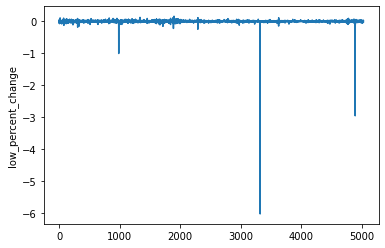

,dates,low_percent_change_0,low_percent_change_1,low_percent_change_2,low_percent_change_3,low_percent_change_4,low_percent_change_5,low_percent_change_6,low_percent_change_7,low_percent_change_8,...,low_percent_change_191,low_percent_change_192,low_percent_change_193,low_percent_change_194,low_percent_change_195,low_percent_change_196,low_percent_change_197,low_percent_change_198,low_percent_change_199,low_percent_change_target
0,2001-03-23,-0.041174,0.035160,-0.018605,0.000000,-0.007498,0.002804,-0.063090,-0.073600,0.062500,...,0.005920,0.035573,0.009569,-0.010549,-0.012912,-0.055451,-0.050346,0.016505,0.014354,0.014616
1,2001-03-26,0.035160,-0.018605,0.000000,-0.007498,0.002804,-0.063090,-0.073600,0.062500,-0.005025,...,0.035573,0.009569,-0.010549,-0.012912,-0.055451,-0.050346,0.016505,0.014354,0.014616,-0.034634
2,2001-03-27,-0.018605,0.000000,-0.007498,0.002804,-0.063090,-0.073600,0.062500,-0.005025,0.007976,...,0.009569,-0.010549,-0.012912,-0.055451,-0.050346,0.016505,0.014354,0.014616,-0.034634,0.062643
3,2001-03-28,0.000000,-0.007498,0.002804,-0.063090,-0.073600,0.062500,-0.005025,0.007976,0.034649,...,-0.010549,-0.012912,-0.055451,-0.050346,0.016505,0.014354,0.014616,-0.034634,0.062643,0.004098
4,2001-03-29,-0.007498,0.002804,-0.063090,-0.073600,0.062500,-0.005025,0.007976,0.034649,0.023496,...,-0.012912,-0.055451,-0.050346,0.016505,0.014354,0.014616,-0.034634,0.062643,0.004098,-0.006416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4822,2020-05-26,-0.010891,0.008047,0.002654,0.002333,0.005393,0.010456,-0.004738,0.007580,0.012495,...,0.012949,0.017759,-0.026018,-0.027146,-0.008931,-0.011703,0.021719,0.005525,0.014927,-0.017623
4823,2020-05-27,0.008047,0.002654,0.002333,0.005393,0.010456,-0.004738,0.007580,0.012495,0.014126,...,0.017759,-0.026018,-0.027146,-0.008931,-0.011703,0.021719,0.005525,0.014927,-0.017623,0.010463
4824,2020-05-28,0.002654,0.002333,0.005393,0.010456,-0.004738,0.007580,0.012495,0.014126,0.040683,...,-0.026018,-0.027146,-0.008931,-0.011703,0.021719,0.005525,0.014927,-0.017623,0.010463,0.034439
4825,2020-05-29,0.002333,0.005393,0.010456,-0.004738,0.007580,0.012495,0.014126,0.040683,-0.031626,...,-0.027146,-0.008931,-0.011703,0.021719,0.005525,0.014927,-0.017623,0.010463,0.034439,-0.019446


In [13]:
sns.lineplot(data=daily_stocks_data[pc_metric])
plt.show()
ts_df = to_ts_df(daily_stocks_data, lookback, pc_metric)
display(ts_df)
# sns.pairplot(daily_stocks_data)
# plt.show()

In [61]:
def deep_lstm(lookback=100):
    model = Sequential()
    model.add(InputLayer(input_shape=(lookback, 1)))
    model.add(GRU(1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics='mse')
    return model

In [62]:
model = deep_lstm()
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (gru_8/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported